<a href="https://colab.research.google.com/github/sandhya-bdb/CNN-model-for-Fruit-Classification-using-ResNet50/blob/main/week_5_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Dataset: Begin by loading the dataset provided.
# Data Augmentation: Apply transformations such as random flip, rotation, color jitter, resizing, etc., to augment the data and enhance model performance.
# Dataset Splitting: Split the dataset into training, validation, and testing sets.
# Visualization: Visualize a few images from the dataset to develop an understanding of the data.

In [7]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [8]:
device = torch.device("cuda" )
device

device(type='cuda')

In [9]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
!find /content/dataset -type d -name ".*" -exec rm -r {} +


In [16]:
!ls -a /content/dataset


.  ..  FRUIT-16K


In [28]:
import os
os.listdir('/content')




['.config', 'dataset', 'dataset.zip', 'sample_data']

In [20]:
!ls -a /content


.  ..  .config	dataset  dataset.zip  sample_data


In [21]:
!ls -a /content/dataset


.  ..  FRUIT-16K


In [14]:
!unzip /content/dataset.zip -d /content/dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/FRUIT-16K/S_Lemon/458.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/935.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/89.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/1000.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/773.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/692.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/854.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/575.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/737.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/656.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/494.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/818.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/100.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/971.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/1.jpg  
  inflating: /content/dataset/FRUIT-16K/S_Lemon/890.jpg  
  inflating: /content/d

In [25]:
dataset_path = "/content/dataset/FRUIT-16K"


In [26]:
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
print(f"Classes found: {dataset.classes}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Number of samples: {len(dataset)}")


Classes found: ['F_Banana', 'F_Lemon', 'F_Lulo', 'F_Mango', 'F_Orange', 'F_Strawberry', 'F_Tamarillo', 'F_Tomato', 'S_Banana', 'S_Lemon', 'S_Lulo', 'S_Mango', 'S_Orange', 'S_Strawberry', 'S_Tamarillo', 'S_Tomato']
Number of classes: 16
Number of samples: 16000


In [27]:
class_names = dataset.classes
class_names

['F_Banana',
 'F_Lemon',
 'F_Lulo',
 'F_Mango',
 'F_Orange',
 'F_Strawberry',
 'F_Tamarillo',
 'F_Tomato',
 'S_Banana',
 'S_Lemon',
 'S_Lulo',
 'S_Mango',
 'S_Orange',
 'S_Strawberry',
 'S_Tamarillo',
 'S_Tomato']

In [48]:
num_classes = len(dataset.classes)
num_classes

16

In [30]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(12000, 4000)

In [31]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [32]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [33]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [34]:
labels[10]

tensor(9)

In [35]:
images[10].shape

torch.Size([3, 224, 224])

In [36]:
images[10].permute(1,2,0).shape

torch.Size([224, 224, 3])

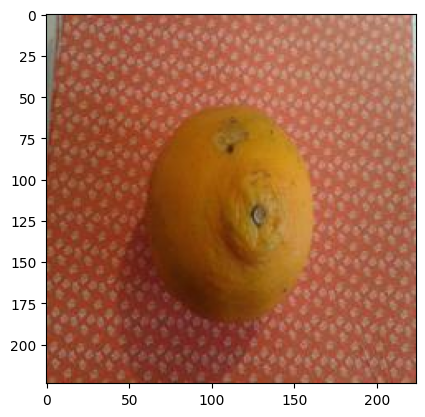

In [37]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

In [38]:
images[30].permute(1,2,0).shape

torch.Size([224, 224, 3])

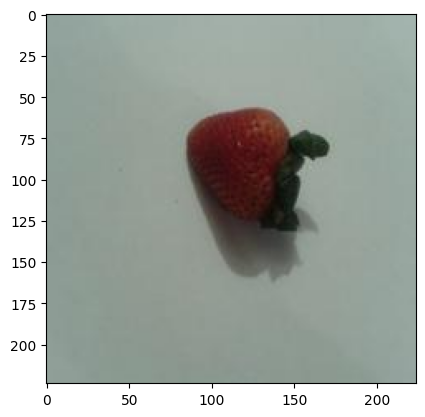

In [39]:
plt.imshow(images[30].permute(1,2,0))
plt.show()

In [40]:
images[15].permute(1,2,0).shape

torch.Size([224, 224, 3])

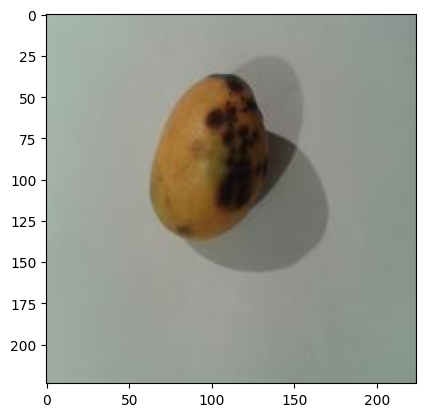

In [41]:
plt.imshow(images[15].permute(1,2,0))
plt.show()

In [ ]:
#Tasks:
#Model Training: Begin by building a CNN model. For this task, avoid using transfer learning or regularization techniques initially.
#Validation and Testing: Evaluate the model on both validation and test datasets.
#Optimize Epochs: Experiment with different numbers of training epochs.

In [42]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## model 1: CNN

In [43]:
class FruitClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [44]:
images.size(0)

32

In [45]:
len(train_loader.dataset)

12000

In [46]:
# 1) DataLoaders with single-threaded loading (helps with notebook timeouts)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=3):
    import time
    start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            if (batch_num + 1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        model.eval()
        correct, total = 0, 0
        all_labels, all_predictions = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        val_accuracy = 100.0 * correct / total if total > 0 else 0.0
        print(f"*** Validation Accuracy: {val_accuracy:.2f}% ***")

    end = time.time()
    print(f"Execution time: {end - start:.2f} seconds")

    return all_labels, all_predictions


In [49]:
model = FruitClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
all_labels, all_predictions = train_model(
    model, criterion, optimizer,
    train_loader, val_loader, device,
    epochs=3
)


Batch: 10, Epoch: 1, Loss: 2.7222
Batch: 20, Epoch: 1, Loss: 2.4651
Batch: 30, Epoch: 1, Loss: 2.4811
Batch: 40, Epoch: 1, Loss: 2.1518
Batch: 50, Epoch: 1, Loss: 2.0790
Batch: 60, Epoch: 1, Loss: 1.7609
Batch: 70, Epoch: 1, Loss: 1.5986
Batch: 80, Epoch: 1, Loss: 1.5655
Batch: 90, Epoch: 1, Loss: 1.1204
Batch: 100, Epoch: 1, Loss: 1.3880
Batch: 110, Epoch: 1, Loss: 0.9750
Batch: 120, Epoch: 1, Loss: 0.9771
Batch: 130, Epoch: 1, Loss: 0.8242
Batch: 140, Epoch: 1, Loss: 0.7605
Batch: 150, Epoch: 1, Loss: 1.2832
Batch: 160, Epoch: 1, Loss: 0.7455
Batch: 170, Epoch: 1, Loss: 0.7938
Batch: 180, Epoch: 1, Loss: 0.5294
Epoch [1/3], Avg Loss: 1.4442
*** Validation Accuracy: 80.42% ***
Batch: 10, Epoch: 2, Loss: 0.3814
Batch: 20, Epoch: 2, Loss: 0.6062
Batch: 30, Epoch: 2, Loss: 0.4267
Batch: 40, Epoch: 2, Loss: 0.5079
Batch: 50, Epoch: 2, Loss: 0.6406
Batch: 60, Epoch: 2, Loss: 0.3857
Batch: 70, Epoch: 2, Loss: 0.5477
Batch: 80, Epoch: 2, Loss: 0.3937
Batch: 90, Epoch: 2, Loss: 0.2826
Batch: 

In [ ]:
#Training and Validation: Plot training and validation accuracy to check for overfitting.
#Regularization Techniques: Apply techniques like batch normalization, weight decay, dropout, and early stopping to improve model performance.
#Hyperparameter Tuning: Experiment with hyperparameters to further increase accuracy.
#Model Saving: Save the best-performing model for future use.

## Model2: CNN with Regularization

In [50]:
class FruitClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [53]:
model = FruitClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
all_labels, all_predictions = train_model(
    model, criterion, optimizer,
    train_loader, val_loader, device,
    epochs=3
)

Batch: 10, Epoch: 1, Loss: 2.7316
Batch: 20, Epoch: 1, Loss: 2.4375
Batch: 30, Epoch: 1, Loss: 1.9318
Batch: 40, Epoch: 1, Loss: 1.6516
Batch: 50, Epoch: 1, Loss: 1.2583
Batch: 60, Epoch: 1, Loss: 1.2913
Batch: 70, Epoch: 1, Loss: 1.0664
Batch: 80, Epoch: 1, Loss: 0.9121
Batch: 90, Epoch: 1, Loss: 0.6789
Batch: 100, Epoch: 1, Loss: 0.8507
Batch: 110, Epoch: 1, Loss: 0.5098
Batch: 120, Epoch: 1, Loss: 0.9799
Batch: 130, Epoch: 1, Loss: 0.7609
Batch: 140, Epoch: 1, Loss: 0.5481
Batch: 150, Epoch: 1, Loss: 0.4575
Batch: 160, Epoch: 1, Loss: 0.7128
Batch: 170, Epoch: 1, Loss: 0.5025
Batch: 180, Epoch: 1, Loss: 0.8349
Epoch [1/3], Avg Loss: 1.1942
*** Validation Accuracy: 81.22% ***
Batch: 10, Epoch: 2, Loss: 0.5280
Batch: 20, Epoch: 2, Loss: 0.3964
Batch: 30, Epoch: 2, Loss: 0.4310
Batch: 40, Epoch: 2, Loss: 0.4197
Batch: 50, Epoch: 2, Loss: 0.2869
Batch: 60, Epoch: 2, Loss: 0.4029
Batch: 70, Epoch: 2, Loss: 0.3569
Batch: 80, Epoch: 2, Loss: 0.3799
Batch: 90, Epoch: 2, Loss: 0.3630
Batch: 

In [ ]:
#Apply Transfer Learning: Use a pre-trained model like ResNet50 to train the model.
#Save the Model: Save the trained model to disk for future use.


##model 3: CNN with ResNet50


In [55]:
# Load the pre-trained ResNet model
class FruitClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [56]:
model = FruitClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(
    model, criterion, optimizer,
    train_loader, val_loader, device,
    epochs=3
)





Batch: 10, Epoch: 1, Loss: 2.7606
Batch: 20, Epoch: 1, Loss: 2.7184
Batch: 30, Epoch: 1, Loss: 2.4732
Batch: 40, Epoch: 1, Loss: 2.3183
Batch: 50, Epoch: 1, Loss: 2.2215
Batch: 60, Epoch: 1, Loss: 1.8346
Batch: 70, Epoch: 1, Loss: 1.8815
Batch: 80, Epoch: 1, Loss: 1.5554
Batch: 90, Epoch: 1, Loss: 1.6543
Batch: 100, Epoch: 1, Loss: 1.5728
Batch: 110, Epoch: 1, Loss: 1.2494
Batch: 120, Epoch: 1, Loss: 1.4309
Batch: 130, Epoch: 1, Loss: 1.1104
Batch: 140, Epoch: 1, Loss: 1.0516
Batch: 150, Epoch: 1, Loss: 1.0629
Batch: 160, Epoch: 1, Loss: 1.0145
Batch: 170, Epoch: 1, Loss: 1.0303
Batch: 180, Epoch: 1, Loss: 0.9418
Epoch [1/3], Avg Loss: 1.7467
*** Validation Accuracy: 72.35% ***
Batch: 10, Epoch: 2, Loss: 0.6470
Batch: 20, Epoch: 2, Loss: 0.7154
Batch: 30, Epoch: 2, Loss: 0.6314
Batch: 40, Epoch: 2, Loss: 0.7177
Batch: 50, Epoch: 2, Loss: 0.6868
Batch: 60, Epoch: 2, Loss: 0.4934
Batch: 70, Epoch: 2, Loss: 0.4978
Batch: 80, Epoch: 2, Loss: 0.5145
Batch: 90, Epoch: 2, Loss: 0.4883
Batch: 

## model 4 : CNN with hyperparameter tuning ResNet50


In [60]:
model = FruitClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)


all_labels, all_predictions = train_model(
    model, criterion, optimizer,
    train_loader, val_loader, device,
    epochs=3
)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]


Batch: 10, Epoch: 1, Loss: 0.4365
Batch: 20, Epoch: 1, Loss: 0.1662
Batch: 30, Epoch: 1, Loss: 0.0996
Batch: 40, Epoch: 1, Loss: 0.0132
Batch: 50, Epoch: 1, Loss: 0.1200
Batch: 60, Epoch: 1, Loss: 0.0376
Batch: 70, Epoch: 1, Loss: 0.1543
Batch: 80, Epoch: 1, Loss: 0.0444
Batch: 90, Epoch: 1, Loss: 0.0239
Batch: 100, Epoch: 1, Loss: 0.0598
Batch: 110, Epoch: 1, Loss: 0.0074
Batch: 120, Epoch: 1, Loss: 0.0032
Batch: 130, Epoch: 1, Loss: 0.3604
Batch: 140, Epoch: 1, Loss: 0.0114
Batch: 150, Epoch: 1, Loss: 0.0020
Batch: 160, Epoch: 1, Loss: 0.0029
Batch: 170, Epoch: 1, Loss: 0.1886
Batch: 180, Epoch: 1, Loss: 0.0007
Epoch [1/3], Avg Loss: 0.1216
*** Validation Accuracy: 99.05% ***
Batch: 10, Epoch: 2, Loss: 0.1069
Batch: 20, Epoch: 2, Loss: 0.0540
Batch: 30, Epoch: 2, Loss: 0.0424
Batch: 40, Epoch: 2, Loss: 0.0267
Batch: 50, Epoch: 2, Loss: 0.0310
Batch: 60, Epoch: 2, Loss: 0.0575
Batch: 70, Epoch: 2, Loss: 0.1922
Batch: 80, Epoch: 2, Loss: 0.0253
Batch: 90, Epoch: 2, Loss: 0.0012
Batch: 

## Model Evaluation using Confusion Matrix and Classification Report


In [62]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       233
           1       1.00      0.99      0.99       272
           2       1.00      0.99      0.99       262
           3       1.00      1.00      1.00       229
           4       1.00      1.00      1.00       245
           5       1.00      1.00      1.00       266
           6       1.00      1.00      1.00       254
           7       1.00      1.00      1.00       244
           8       1.00      1.00      1.00       240
           9       0.99      1.00      0.99       245
          10       0.98      1.00      0.99       252
          11       1.00      1.00      1.00       233
          12       1.00      0.99      1.00       265
          13       1.00      1.00      1.00       258
          14       1.00      1.00      1.00       234
          15       0.98      1.00      0.99       268

    accuracy                           1.00      4000
   macro avg       1.00   

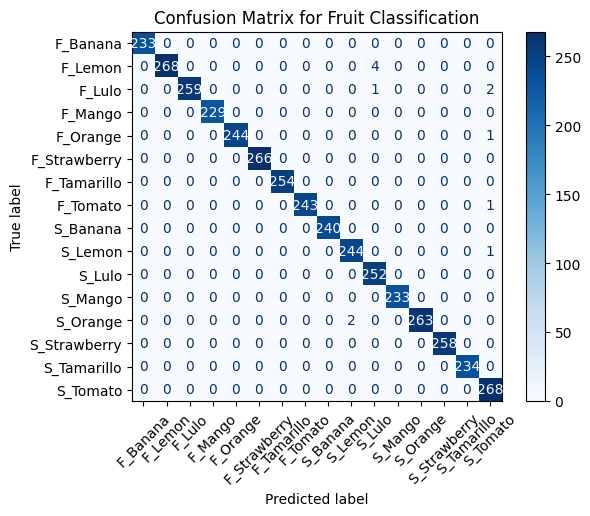

In [63]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Fruit Classification")
plt.show()

## Saving the model

In [64]:
torch.save(model.state_dict(), 'saved_model.pth')